# Build Neural network from scratch

In this project, I'll build neural network and use it to predict student admissions.



# Predicting Student Admissions with Neural Networks
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

## Loading the data
To load the data and format it nicely, we will use two very useful packages called Pandas and Numpy. You can read on the documentation here:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Importing pandas matplotlib and numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# Reading the csv file into a pandas DataFrame
data = pd.read_csv('data/student_data.csv')

# Printing out the first 10 rows of our data
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

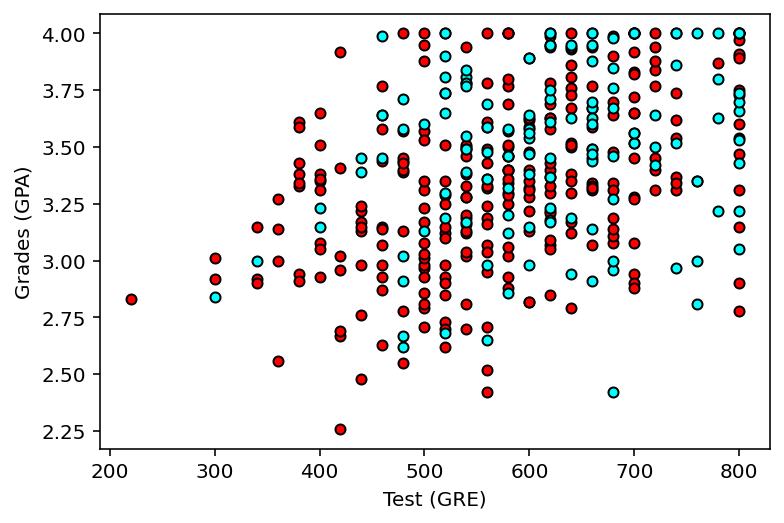

In [3]:
# %matplotlib inline
import matplotlib.pyplot as plt

# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre","gpa","rank"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

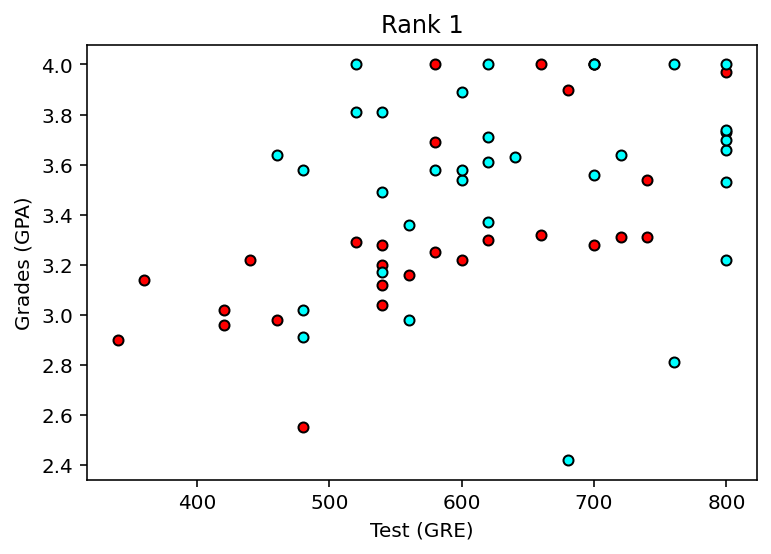

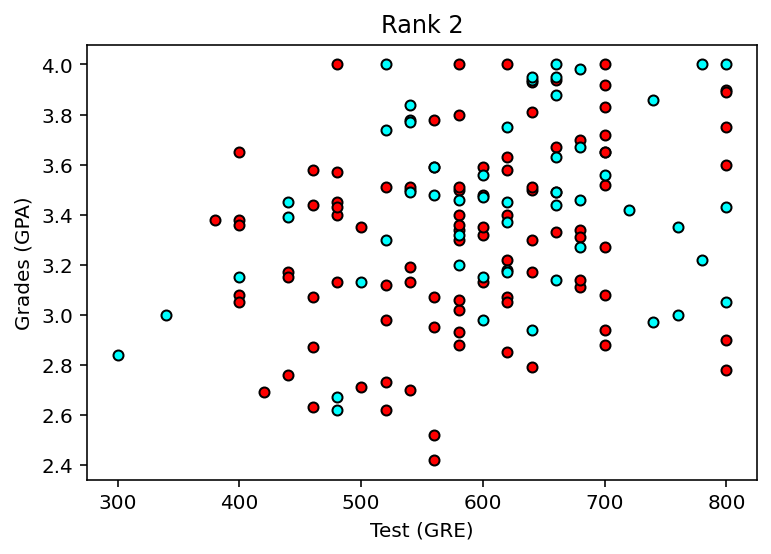

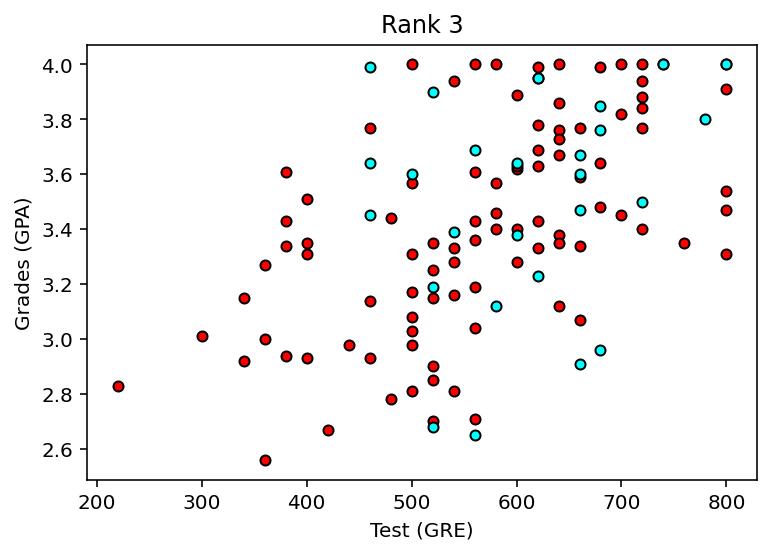

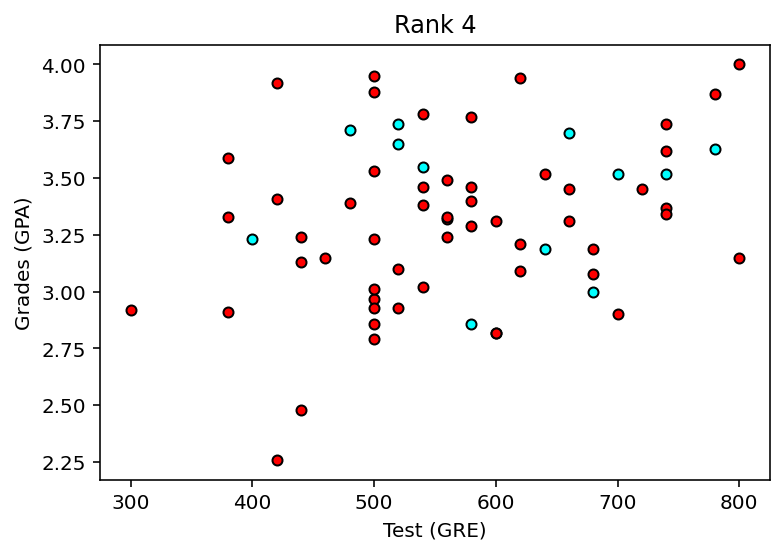

In [4]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## TODO: One-hot encoding the rank
Use the `get_dummies` function in pandas in order to one-hot encode the data.

Hint: To drop a column, it's suggested that you use `one_hot_data`[.drop( )](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html).

In [5]:
## One solution
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]
## Alternative solution ##
# if you're using an up-to-date version of pandas, 
# you can also use selection by columns

# an equally valid solution
one_hot_data = pd.get_dummies(data, columns=['rank'])
one_hot_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


## TODO: Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [6]:
# Copying our data
processed_data = one_hot_data[:]

# Scaling the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4.0
processed_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1
5,1,0.950,0.7500,0,1,0,0
6,1,0.700,0.7450,1,0,0,0
7,0,0.500,0.7700,0,1,0,0
8,1,0.675,0.8475,0,0,1,0
9,0,0.875,0.9800,0,1,0,0


## Splitting the data into Training and Testing
In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [7]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
train_data.head()

Number of training samples is 360
Number of testing samples is 40


,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
61,0,0.700,0.8300,0,0,0,1
42,1,0.750,0.7875,0,1,0,0
122,0,0.650,0.7125,0,0,1,0
106,1,0.875,0.8900,1,0,0,0
136,0,0.700,0.8325,0,0,0,1


In [8]:
test_data.head()

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
7,0,0.500,0.7700,0,1,0,0
8,1,0.675,0.8475,0,0,1,0
9,0,0.875,0.9800,0,1,0,0
17,0,0.450,0.6400,0,0,1,0
31,0,0.950,0.8375,0,0,1,0


## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

In [9]:
features = train_data.drop('admit', axis=1)
targets = train_data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

features.head()

,gre,gpa,rank_1,rank_2,rank_3,rank_4
61,0.700,0.8300,0,0,0,1
42,0.750,0.7875,0,1,0,0
122,0.650,0.7125,0,0,1,0
106,0.875,0.8900,1,0,0,0
136,0.700,0.8325,0,0,0,1


In [10]:
targets.head()

61     0
42     1
122    0
106    1
136    0
Name: admit, dtype: int64

## Time to build the network

Below we'll build your network. we'll implement both the forward pass and backwards pass through the network. we'll also set the hyperparameters: the learning rate, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** we'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, we have these tasks:
1. Implement the sigmoid function to use as the activation function.
2. Implement the forward pass .
3. Implement the backpropagation algorithm, including calculating the output error.
4. Implement the forward pass.

In [11]:
# Activation (sigmoid) function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1-sigmoid(x))
def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

# TODO: Backpropagate the error
Now it's your turn to shine. Write the error term. Remember that this is given by the equation $$ (y-\hat{y})x $$ for binary cross entropy loss function and 
$$ (y-\hat{y})\sigma'(x)x $$ for mean square error. 

In [12]:
def error_term_formula(x, y, output):
#    for binary cross entropy loss
    return (y - output)*x
#    for mean square error
#    return (y - output)*sigmoid_prime(x)*x

In [13]:
# Neural Network hyperparameters
epochs = 20000
learnrate = 0.000001

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            # Loop through all records, x is the input, y is the target

            # Activation of the output unit
            #   Notice we multiply the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(x, weights))

            # The error term
            error_term = error_term_formula(x, y, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term

        # Update the weights here. The learning rate times the 
        # change in weights
        # don't have to divide by n_records since it is compensated by the learning rate
        weights += learnrate * del_w #/ n_records  

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean(error_formula(targets, out))
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(features, targets, epochs, learnrate)

Epoch: 0
Train loss:  0.7526069338149117
Epoch: 2000
Train loss:  0.6959803584452579
Epoch: 4000
Train loss:  0.6627971322826716
Epoch: 6000
Train loss:  0.6432613555009693
Epoch: 8000
Train loss:  0.6315837852106555
Epoch: 10000
Train loss:  0.6244431366949671
Epoch: 12000
Train loss:  0.6199459094193018
Epoch: 14000
Train loss:  0.6170076450746552
Epoch: 16000
Train loss:  0.615001636720849
Epoch: 18000
Train loss:  0.6135619630042787
Finished training!


In [14]:
# Calculate accuracy on test data
test_out = sigmoid(np.dot(features_test, weights))
predictions = test_out > 0.5
accuracy = np.mean(predictions == targets_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.675
